<a href="https://colab.research.google.com/github/anushkaa-ambuj/Knowledge-Distillation-of-Chest-X-Ray-Images/blob/main/HKD_Cifar10-Task%202(ii).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Teacher: DenseNet 121 <br>
Senior Student: Resnet 34 <br>
Student: MobileNet

Dataset: CIFAR 10</b>

## Import Dependancies

In [ ]:
!pip install torchinfo

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torchinfo
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.utils import make_grid
#import timer

## Define the device to use

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Transformations

Currently, not utilzing any data transformations

In [ ]:
# Define the transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## Import the Dataset
### Splitting the Dataset

In [ ]:
# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                 download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:10<00:00, 16491584.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

## Data Loader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

## Teacher Model

### Initializing the Teacher model

In [ ]:
#teacher = models.densenet121(pretrained=True)
#num_ftrs = teacher.classifier.in_features
#print("num_ftrs=",num_ftrs)
#teacher.classifier = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes
#teacher.to(device)

In [ ]:
teacher = models.densenet121(pretrained=True)
num_ftrs = teacher.classifier.in_features
teacher.classifier = nn.Linear(num_ftrs, 10)
teacher.load_state_dict(torch.load('model_teacher'))
teacher.to(device)
teacher.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Teacher Model Summary

In [ ]:
torchinfo.summary(teacher, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DenseNet                                 [1, 3, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 1024, 7, 7]           --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         [1, 64, 56, 56]           --

### Train Teacher Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs = 35

In [ ]:
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs):
    l1 = []; a1 = []
    l2 = []; a2 = []

    #start = timer()
    for i, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = teacher(img)

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        loss = criterion(output, labels)
        l1.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for img, lbl in valloader:
        img = img.to(device)
        lbl = lbl.to(device)
        output = teacher(img)

        loss = criterion(output,lbl)
        l2.append(loss.item())

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == lbl).item() / len(preds))
        a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    #end = timer()
    #time = end - start
    #time = time/60

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')
    #print(f'Epoch {epoch+1}: Train Loss==> {np.mean(train_loss):.2f} Train_Acc==> {np.mean(train_acc)*100 :.3f} % Val Loss==> {np.mean(val_loss):.2f} Val_Acc==> {np.mean(val_acc)*100 :.3f} % Time==> {time:.2f} mins')

### Epoch vs Loss, Epoch vs Accuracy Graphs

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Classification Metrics & Confusion Matrix

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.7649
Confusion Matrix: 
 [[822  36  21  17  20  12   8   9  32  23]
 [ 11 898   4   8   0   6   2   6  15  50]
 [ 84   0 679  60  59  35  41  25   9   8]
 [ 23   8  52 617  53 140  44  48   9   6]
 [ 31   1  59  56 724  36  38  46   8   1]
 [ 18   0  34 200  44 631  13  45   4  11]
 [ 10   6  41  66  18  37 802  10   4   6]
 [ 15   3  22  40  44  39   5 822   1   9]
 [ 62  35   6  13   5   6   5   5 844  19]
 [ 33  95   8  10   5   8   5  14  12 810]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.74      0.82      0.78      1000
         car       0.83      0.90      0.86      1000
        bird       0.73      0.68      0.71      1000
         cat       0.57      0.62      0.59      1000
        deer       0.74      0.72      0.73      1000
         dog       0.66      0.63      0.65      1000
        frog       0.83      0.80      0.82      1000
       horse       0.80      0.82      0.81      1000
        ship       0.90

## Senior Student Model

### Initializing the model

In [ ]:
# Define ResNet34
senior = models.resnet34(pretrained=False)
num_ftrs = senior.fc.in_features
print("num_ftrs=",num_ftrs)
senior.fc = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes
senior.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


num_ftrs= 512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torchinfo.summary(senior, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 3, 224, 224]          [1, 10]                   --                        --                        --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           --

### Training the Senior Student model

In [ ]:
# Define the temperature for softening the logits
T = 4

# Define the optimizer for training the MobileNet model
optimizer2 = optim.SGD(senior.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
epochs2 = 35

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# Assuming you have defined the 'senior' and 'teacher' models and initialized them

def train_senior_teacher(senior, teacher, trainloader, valloader, epochs, T, device, optimizer2):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs2):
        l1 = []
        l2 = []
        a1 = []
        a2 = []

        for i, (img, labels) in enumerate(trainloader):
            img = img.to(device)
            labels = labels.to(device)
            output = senior(img)

            # Accuracy
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == labels).item() / len(preds))
            a1.append(acc)

            # Loss
            compare = teacher(img)
            pdist = F.softmax(compare / T, dim=1)
            soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss = 0.4 * loss + 0.6 * soft_loss_teacher
            l1.append(loss.item())

            # Backpropagation
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

        for img, lbl in valloader:
            img = img.to(device)
            lbl = lbl.to(device)
            output = senior(img)
            loss = nn.CrossEntropyLoss()(output, lbl)
            l2.append(loss.item())
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == lbl).item() / len(preds))
            a2.append(acc)

        train_loss.append(np.mean(l1))
        val_loss.append(np.mean(l2))
        train_acc.append(np.mean(a1))
        val_acc.append(np.mean(a2))

        print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_senior_teacher(senior, teacher, trainloader, valloader, epochs2, T, device, optimizer2)

Epoch 1: Train Loss==> 1.32 Train_Acc==> 20.908 % Val Loss==> 2.00  Val_Acc==> 26.951 %
Epoch 2: Train Loss==> 1.14 Train_Acc==> 31.580 % Val Loss==> 1.81  Val_Acc==> 34.246 %
Epoch 3: Train Loss==> 1.04 Train_Acc==> 37.060 % Val Loss==> 1.70  Val_Acc==> 38.057 %
Epoch 4: Train Loss==> 0.98 Train_Acc==> 40.940 % Val Loss==> 1.62  Val_Acc==> 41.929 %
Epoch 5: Train Loss==> 0.93 Train_Acc==> 44.492 % Val Loss==> 1.57  Val_Acc==> 43.959 %
Epoch 6: Train Loss==> 0.88 Train_Acc==> 47.082 % Val Loss==> 1.54  Val_Acc==> 45.551 %
Epoch 7: Train Loss==> 0.85 Train_Acc==> 49.352 % Val Loss==> 1.51  Val_Acc==> 47.024 %
Epoch 8: Train Loss==> 0.81 Train_Acc==> 51.228 % Val Loss==> 1.48  Val_Acc==> 47.980 %
Epoch 9: Train Loss==> 0.78 Train_Acc==> 53.117 % Val Loss==> 1.48  Val_Acc==> 48.716 %
Epoch 10: Train Loss==> 0.76 Train_Acc==> 55.008 % Val Loss==> 1.47  Val_Acc==> 48.925 %
Epoch 11: Train Loss==> 0.73 Train_Acc==> 56.778 % Val Loss==> 1.46  Val_Acc==> 49.552 %
Epoch 12: Train Loss==> 0.70 T

KeyboardInterrupt: ignored

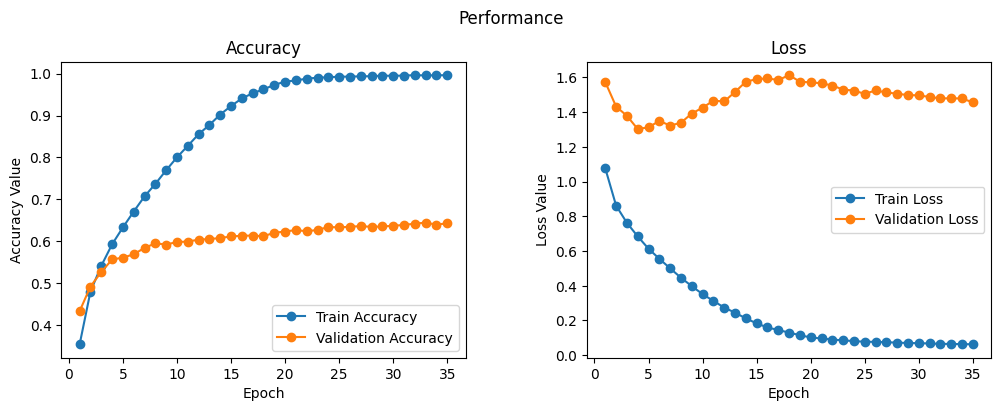

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs2+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
torch.save(senior.state_dict(), 'model_senior')

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = senior(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.7212
Confusion Matrix: 
 [[833  18  39   7  25  12  12  11  36   7]
 [ 29 851   5  11   4   5   4   4  26  61]
 [ 64   6 601  39 102  73  61  31  18   5]
 [ 26  13  54 475 101 196  75  37   8  15]
 [ 28   5  58  31 757  35  41  33  10   2]
 [ 13   4  33 136  65 632  36  64  13   4]
 [  5   5  29  52  63  24 792   9   9  12]
 [ 23   3  26  31  71  51   8 770  10   7]
 [ 96  32  18  15   5   8   7   3 808   8]
 [ 65 103  13  14   6  26  13  19  48 693]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.70      0.83      0.76      1000
         car       0.82      0.85      0.83      1000
        bird       0.69      0.60      0.64      1000
         cat       0.59      0.47      0.52      1000
        deer       0.63      0.76      0.69      1000
         dog       0.60      0.63      0.61      1000
        frog       0.76      0.79      0.77      1000
       horse       0.78      0.77      0.78      1000
        ship       0.82

## Student Model

### Initializing the model

In [ ]:
# Define the MobileNet architecture
student = models.mobilenet_v2(pretrained=False)
num_ftrs = student.classifier[1].in_features
print ("num_ftrs=", num_ftrs)
student.classifier[1] = nn.Linear(num_ftrs, 10)
student.to(device)

num_ftrs= 1280


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
torchinfo.summary(student, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                        [1, 3, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    10,838,016
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3               

### Training the student model

In [ ]:
# Define the optimizer for training the Resnet-18 model
optimizer3 = optim.SGD(student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs3 = 30

In [ ]:
# Train the Resnet-18 model with knowledge distillation
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs3):
    l1 = []; l2 = []
    a1 = []; a2 = []

    for i, (img,labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = student(img)

        # Accuracy
        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        # Loss
        compare = senior(img)
        pdist = F.softmax(compare/T,dim=1)
        soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
        loss = nn.CrossEntropyLoss()(output,labels)
        loss = 0.4*loss + 0.6*soft_loss_teacher
        l1.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()

    for img,lbl in valloader:
                img = img.to(device)
                lbl = lbl.to(device)
                output = student(img)
                loss = nn.CrossEntropyLoss()(output,lbl)
                l2.append(loss.item())
                probs = F.softmax(output,dim=1)
                max_prob,preds = torch.max(probs,dim=1)
                acc = (torch.sum(preds == lbl).item() / len(preds))
                a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

Epoch 1: Train Loss==> 1.52 Train_Acc==> 19.715 % Val Loss==> 2.40  Val_Acc==> 20.830 %
Epoch 2: Train Loss==> 1.12 Train_Acc==> 27.255 % Val Loss==> 1.91  Val_Acc==> 29.021 %
Epoch 3: Train Loss==> 1.02 Train_Acc==> 32.385 % Val Loss==> 1.80  Val_Acc==> 35.261 %
Epoch 4: Train Loss==> 0.94 Train_Acc==> 36.880 % Val Loss==> 1.73  Val_Acc==> 37.520 %
Epoch 5: Train Loss==> 0.89 Train_Acc==> 39.685 % Val Loss==> 1.63  Val_Acc==> 41.103 %
Epoch 6: Train Loss==> 0.86 Train_Acc==> 41.845 % Val Loss==> 1.63  Val_Acc==> 40.943 %
Epoch 7: Train Loss==> 0.84 Train_Acc==> 43.115 % Val Loss==> 1.64  Val_Acc==> 39.689 %
Epoch 8: Train Loss==> 0.83 Train_Acc==> 44.315 % Val Loss==> 1.55  Val_Acc==> 44.974 %
Epoch 9: Train Loss==> 0.79 Train_Acc==> 46.705 % Val Loss==> 1.46  Val_Acc==> 46.955 %
Epoch 10: Train Loss==> 0.75 Train_Acc==> 49.473 % Val Loss==> 1.46  Val_Acc==> 48.020 %
Epoch 11: Train Loss==> 0.72 Train_Acc==> 51.892 % Val Loss==> 1.47  Val_Acc==> 49.194 %
Epoch 12: Train Loss==> 0.70 T

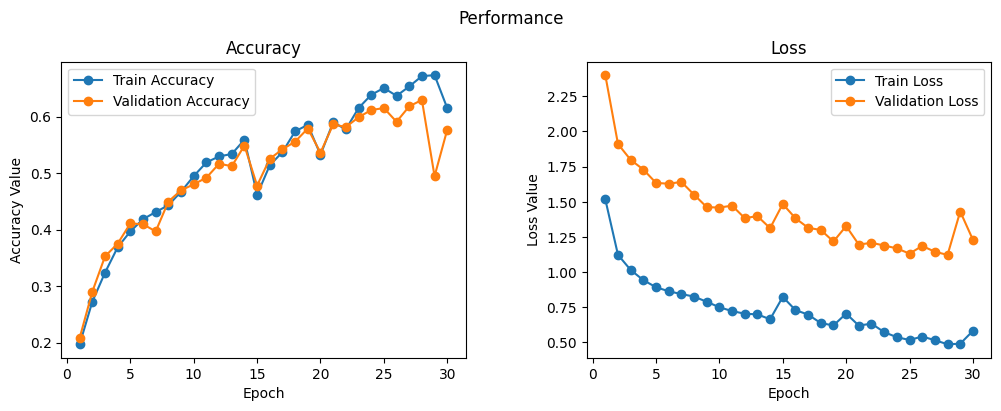

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs3+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs3+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs3+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# Save the seniorstudent_model
filename = 'student_model.sav'
pickle.dump(student, open(filename, 'wb'))

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = student(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.5748
Confusion Matrix: 
 [[599  29  86  16  44   9   8  12 134  63]
 [ 65 654   6  14  13   9   7   4  59 169]
 [ 64  11 460  54 149 123  57  30  27  25]
 [ 19  19  87 237  83 351  74  32  27  71]
 [ 30  11 116  39 517 117  51  96   6  17]
 [  6   7  87  88  71 618  29  51  11  32]
 [ 11  18  57  41 104  61 662  10   8  28]
 [ 17   7  36  31  83 139   8 600   4  75]
 [150  46  25  19  18  12   5   6 684  35]
 [ 59  92  15  16   7  13  11  24  46 717]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.59      0.60      0.59      1000
         car       0.73      0.65      0.69      1000
        bird       0.47      0.46      0.47      1000
         cat       0.43      0.24      0.30      1000
        deer       0.47      0.52      0.49      1000
         dog       0.43      0.62      0.50      1000
        frog       0.73      0.66      0.69      1000
       horse       0.69      0.60      0.64      1000
        ship       0.68